In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
artworks = pd.read_csv('https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv')

In [3]:
artworks.columns

Index(['Title', 'Artist', 'ConstituentID', 'ArtistBio', 'Nationality',
       'BeginDate', 'EndDate', 'Gender', 'Date', 'Medium', 'Dimensions',
       'CreditLine', 'AccessionNumber', 'Classification', 'Department',
       'DateAcquired', 'Cataloged', 'ObjectID', 'URL', 'ThumbnailURL',
       'Circumference (cm)', 'Depth (cm)', 'Diameter (cm)', 'Height (cm)',
       'Length (cm)', 'Weight (kg)', 'Width (cm)', 'Seat Height (cm)',
       'Duration (sec.)'],
      dtype='object')

In [4]:
# Select Columns.
artworks = artworks[['Artist', 'Nationality', 'Gender', 'Date', 'Department',
                    'DateAcquired', 'URL', 'ThumbnailURL', 'Height (cm)', 'Width (cm)']]

# Convert URL's to booleans.
artworks['URL'] = artworks['URL'].notnull()
artworks['ThumbnailURL'] = artworks['ThumbnailURL'].notnull()

# Drop films and some other tricky rows.
artworks = artworks[artworks['Department']!='Film']
artworks = artworks[artworks['Department']!='Media and Performance Art']
artworks = artworks[artworks['Department']!='Fluxus Collection']

# Drop missing data.
artworks = artworks.dropna()

In [5]:
# Get data types.
artworks.dtypes

Artist           object
Nationality      object
Gender           object
Date             object
Department       object
DateAcquired     object
URL                bool
ThumbnailURL       bool
Height (cm)     float64
Width (cm)      float64
dtype: object

In [6]:
artworks['DateAcquired'] = pd.to_datetime(artworks.DateAcquired)
artworks['YearAcquired'] = artworks.DateAcquired.dt.year
artworks['YearAcquired'].dtype

dtype('int64')

In [7]:
# Remove multiple nationalities, genders, and artists.
artworks.loc[artworks['Gender'].str.contains('\) \('), 'Gender'] = '\(multiple_persons\)'
artworks.loc[artworks['Nationality'].str.contains('\) \('), 'Nationality'] = '\(multiple_nationalities\)'
artworks.loc[artworks['Artist'].str.contains(','), 'Artist'] = 'Multiple_Artists'

# Convert dates to start date, cutting down number of distinct examples.
artworks['Date'] = pd.Series(artworks.Date.str.extract(
    '([0-9]{4})', expand=False))[:-1]

# Final column drops and NA drop.
X = artworks.drop(['Department', 'DateAcquired', 'Artist', 'Nationality', 'Date'], 1)

# Create dummies separately.
artists = pd.get_dummies(artworks.Artist)
nationalities = pd.get_dummies(artworks.Nationality)
dates = pd.get_dummies(artworks.Date)

# Concat with other variables, but artists slows this wayyyyy down so we'll keep it out for now
X = pd.get_dummies(X, sparse=True)
X = pd.concat([X, nationalities, dates], axis=1)

Y = artworks.Department

In [8]:
# Alright! We've done our prep, let's build the model.
# Neural networks are hugely computationally intensive.
# This may take several minutes to run.

# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [9]:
mlp.score(X, Y)

0.6526336944455078

In [10]:
Y.value_counts()/len(Y)

Prints & Illustrated Books    0.522030
Photography                   0.229482
Architecture & Design         0.111071
Drawings                      0.103175
Painting & Sculpture          0.034242
Name: Department, dtype: float64

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X, Y, cv=5)

array([0.61509019, 0.60983779, 0.51485717, 0.50844619, 0.5273258 ])

# Time for some drills

Let's do all of that all over again, but with less data and more hparams.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

In [16]:
mlp2 = MLPClassifier(hidden_layer_sizes=(500,250,300), alpha=.0005, )
mlp2.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0005, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(500, 250, 300), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

This took 11 minutes to fit. wow.

In [18]:
print(mlp2.score(X_train, y_train))
print(mlp2.score(X_test, y_test))
cross_val_score(mlp2, X_train, y_train, cv=5)

0.6837269838839337
0.681774681315316


/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


array([0.64016456, 0.65521531, 0.64599483, 0.67075038, 0.7082416 ])

Scored better than the example and barely moved when using the test data.

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


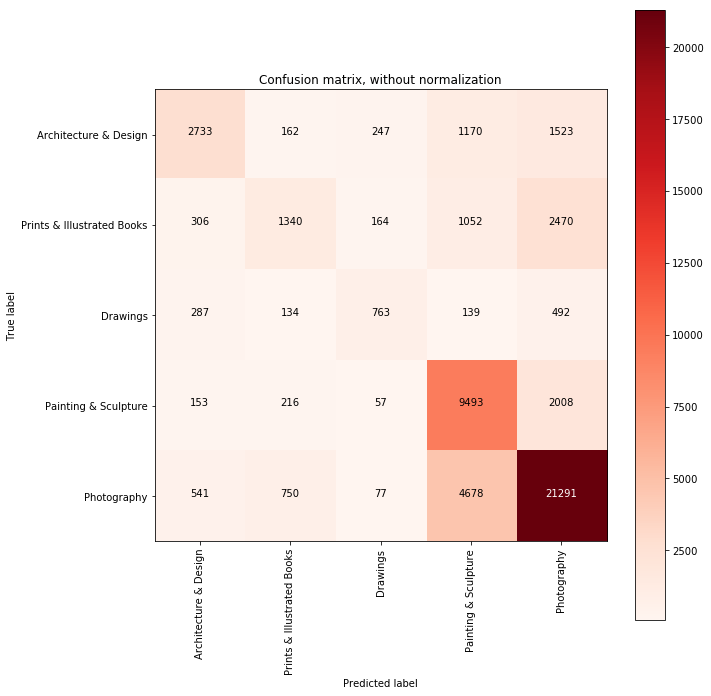

In [22]:
from sklearn import metrics
import itertools

y_pred = mlp2.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = artworks.Department.unique()

plt.figure(figsize=(10, 10))
plot_confusion_matrix(c_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()


In [23]:
mlp2.coefs_

[array([[ 2.92474188e-001, -1.52526701e+000,  5.34603118e-001, ...,
          8.02566052e-002,  1.38651745e-001,  1.84040176e-235],
        [ 3.72657009e-001,  9.91590197e-003, -4.21926751e-001, ...,
         -2.67057482e-001, -1.46556460e-002, -2.06554662e-235],
        [-5.79547978e-002,  4.29514495e-002,  3.23494469e-002, ...,
         -1.01592435e-001,  4.00910443e-003,  3.92498515e-112],
        ...,
        [-2.68238245e-001,  9.49033744e-001,  9.54984037e-002, ...,
          3.62032826e-001, -1.82334516e-005, -2.34549690e-259],
        [-1.25372264e-001,  6.96401030e-001, -1.40817682e-001, ...,
          4.06597421e-001, -6.83211952e-007,  1.31592651e-256],
        [-1.59455001e-002,  6.44364133e-001, -5.77499759e-001, ...,
          3.75646464e-002, -2.66302997e-011,  1.07205881e-256]]),
 array([[-2.76033285e-002,  4.01063557e-002, -2.22906648e-260, ...,
          4.34627307e-002,  5.59798865e-003, -5.43931813e-003],
        [-1.42530828e-002, -6.22386833e-002,  7.95979139e-259